In [2]:
import math
import sys
sys.path.insert(0,'..')
from citylearn.utilities import read_json
from doe_xstock.data import CityLearnData
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from src.occ_citylearn import OCCCityLearnEnv
from src.utilities import DataHandler, FileHandler

# Sanity Checks
---

## Confirm there is no cooling demand

Since the LSTMs are trained for strictly either cooling or heating, need to confirm that there is not cooling in the buildings for the considered months to avoid a situation where the indoor temperature is being driven by cooling loads that are not accounted for during LSTM modeling. In the building files, cooling load is set to zero so we need to make sure that in the training data, cooling load has little to no effect.

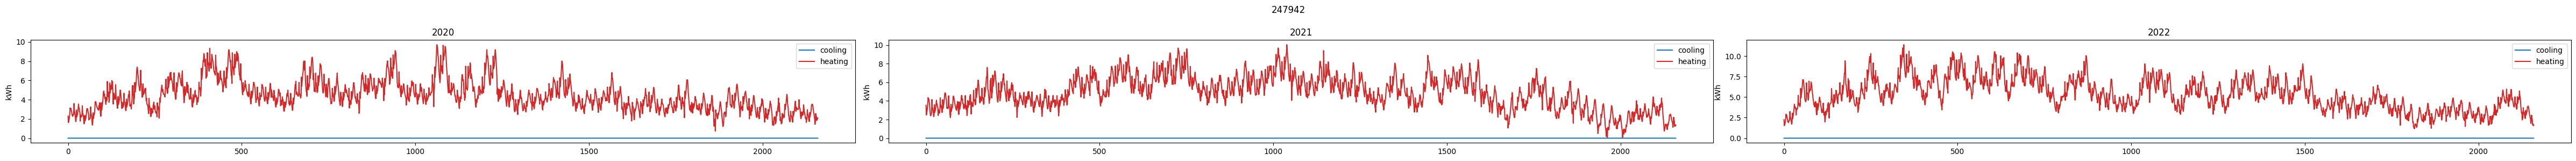

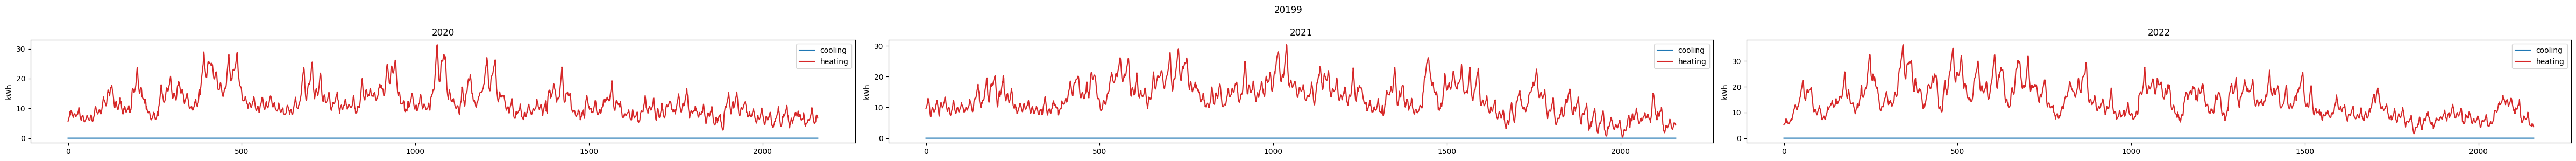

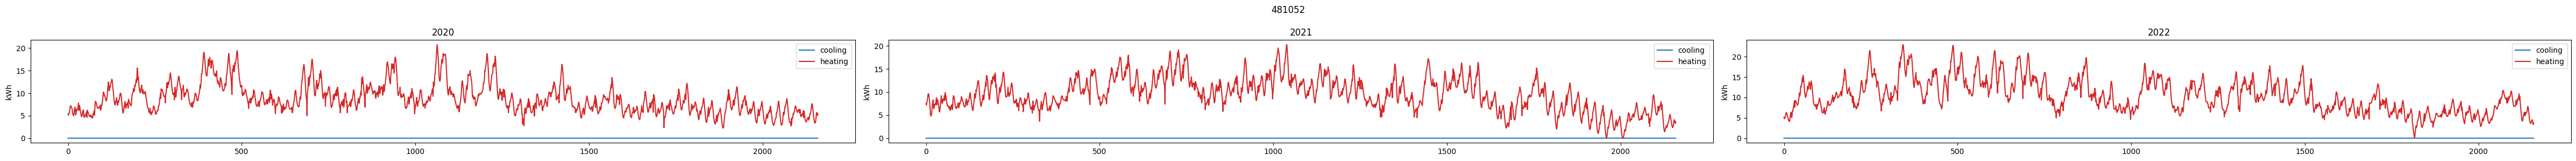

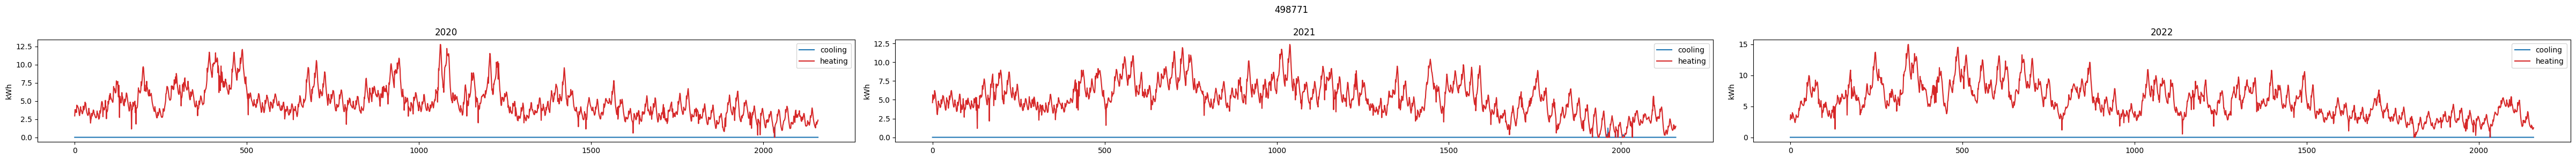

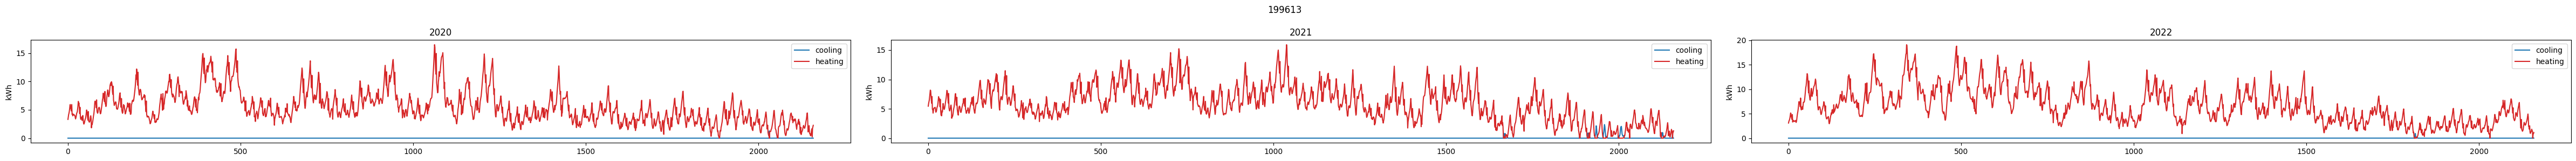

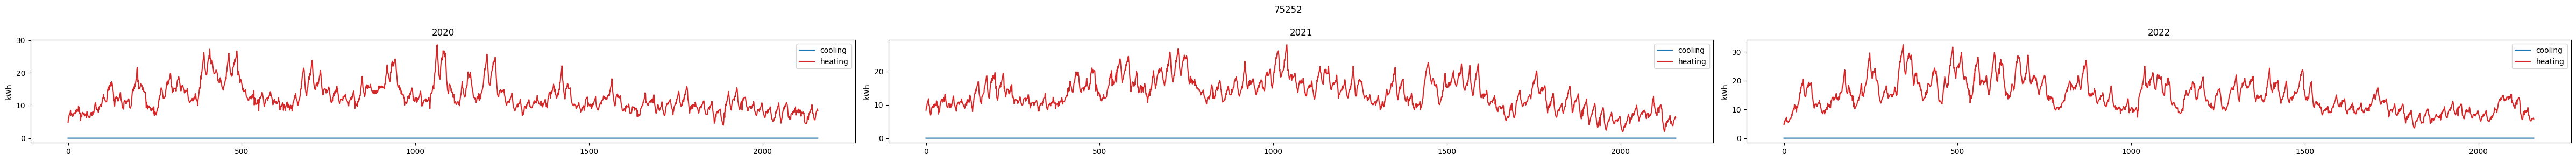

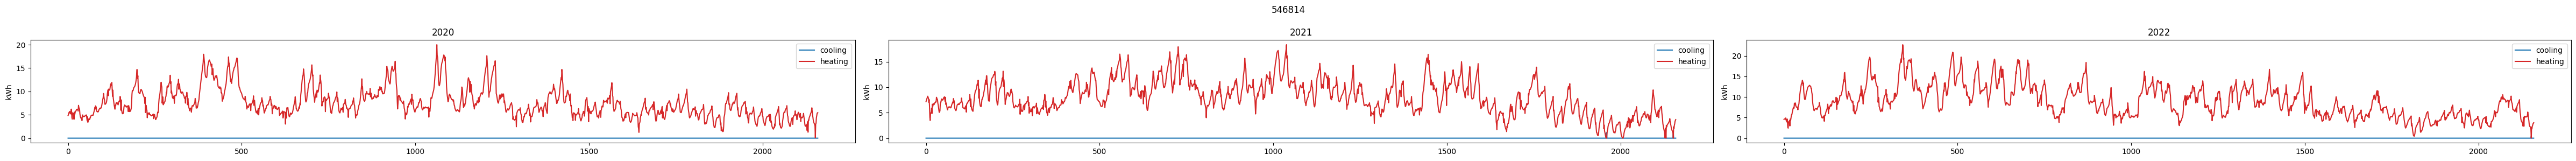

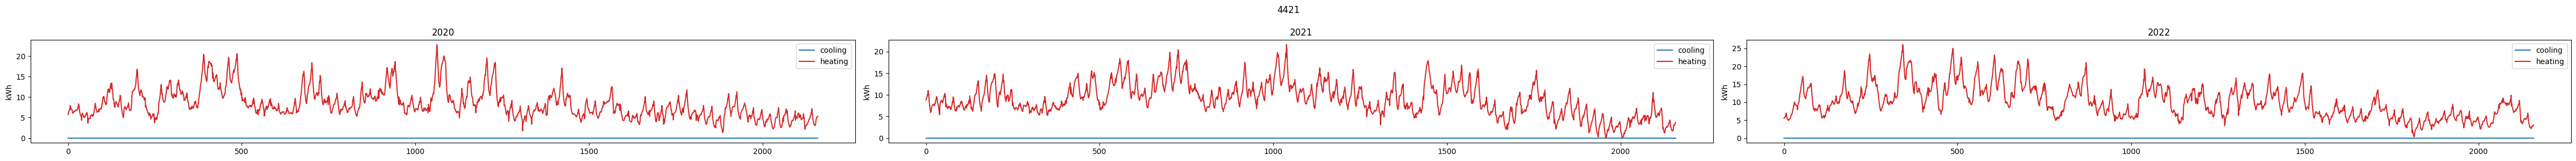

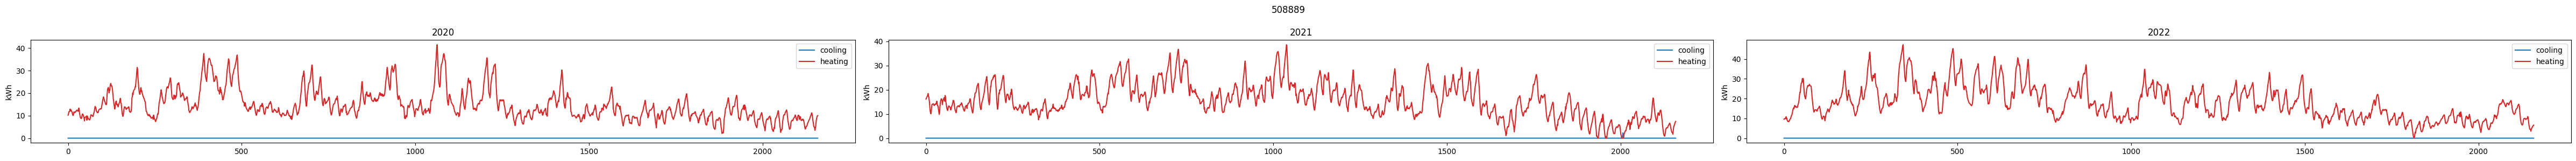

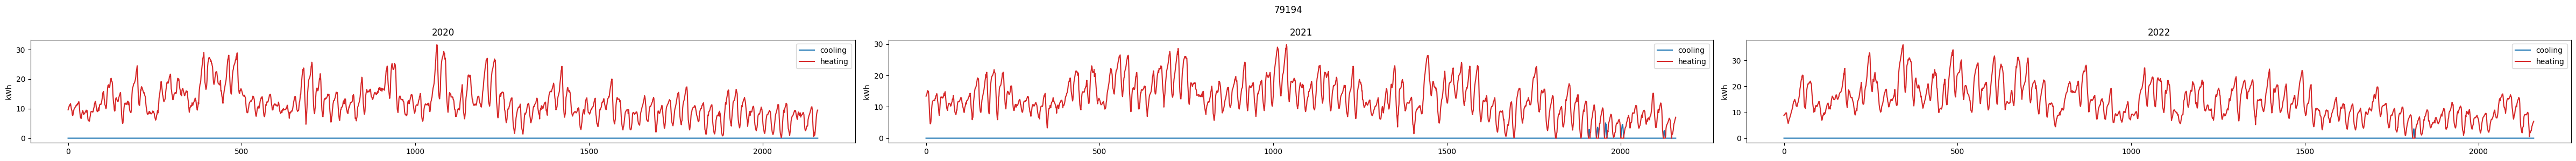

Cooling Load (kWh)                                          \
                          count      mean       std       min       25%   
bldg_id year                                                              
4421    2021                1.0  0.463508       NaN  0.463508  0.463508   
79194   2021               37.0  1.921348  1.491894  0.005756  0.494065   
        2022                7.0  1.836789  1.381443  0.012279  0.775907   
199613  2020                7.0  0.246721  0.471174  0.007544  0.018912   
        2021               68.0  0.591411  0.613649  0.000528  0.075722   
        2022               12.0  0.323393  0.360018  0.000491  0.073033   
247942  2021                1.0  0.019591       NaN  0.019591  0.019591   
481052  2021                3.0  0.052915  0.066716  0.007214  0.014635   
        2022                1.0  0.018313       NaN  0.018313  0.018313   
498771  2020                1.0  1.357793       NaN  1.357793  1.357793   
        2021               22.0  0.290796  0.307250  0.001910  0.042491   
        2022                2.0  0.681674  0.238474  0.513047  0.597360   
508889  2021               10.0  0.684551  0.671607  0.006355  0.263010   
546814  2021                5.0  0.676791  0.598748  0.014066  0.054359   
        2022                1.0  0.422677       NaN  0.422677  0.422677   

                                            
                   50%       75%       max  
bldg_id year                                
4421    2021  0.463508  0.463508  0.463508  
79194   2021  1.722017  2.905682  4.865901  
        2022  1.762870  2.945306  3.639949  
199613  2020  0.046743  0.169721  1.295491  
        2021  0.383496  0.854747  2.312252  
        2022  0.132877  0.485260  0.938679  
247942  2021  0.019591  0.019591  0.019591  
481052  2021  0.022057  0.075766  0.129474  
        2022  0.018313  0.018313  0.018313  
498771  2020  1.357793  1.357793  1.357793  
        2021  0.247474  0.357756  1.229516  
        2022  0.681674  0.765987  0.850301  
508889  2021  0.478530  0.894593  2.188883  
546814  2021  0.948669  1.083217  1.283645  
        2022  0.422677  0.422677  0.422677

In [3]:
settings = FileHandler.get_settings()
years = [2020, 2021, 2022]
data_list = []

for bldg_id, setpoint_id in zip(settings['building_selection']['bldg_ids'], settings['building_selection']['setpoint_ids']):
    bldg_name = str(bldg_id)
    fig, ax = plt.subplots(1, len(years), figsize=(16*len(years), 3.0))

    for ax, year in zip(fig.axes, years):
        kwargs = {
            'simulation_output_directory': FileHandler.ENERGYPLUS_SIMULATION_OUTPUT_DIRECTORY,
            'simulation_id': f'{bldg_id}-{year}',
            'bldg_id': bldg_id,
            **settings['resstock_dataset'],
        }
        data = CityLearnData.get_building_data(**kwargs)
        data = data[data['Month'].isin(settings['months'])].copy()
        data['bldg_id'] = bldg_id
        data['year'] = year
        data_list.append(data)
        y1 = data['Cooling Load (kWh)'].tolist()
        y2 = data['Heating Load (kWh)'].tolist()
        ax.plot(y1, label='cooling', color='tab:blue')
        ax.plot(y2, label='heating', color='tab:red')
        ax.set_ylabel('kWh')
        ax.set_title(f'{year}')
        ax.legend()
        # ax.margins(0)
    
    fig.suptitle(bldg_id)
    plt.tight_layout()
    plt.show()

data = pd.concat(data_list, ignore_index=True)
display(data[data['Cooling Load (kWh)']>0.0].groupby(['bldg_id', 'year'])[['Cooling Load (kWh)']].describe())

# Check LSTM indoor temperature prediction quality compared to train data (LOD1)
---

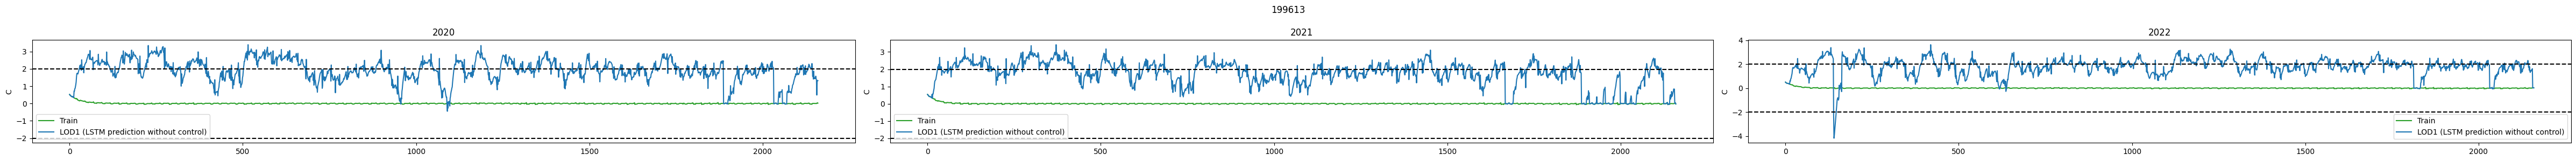

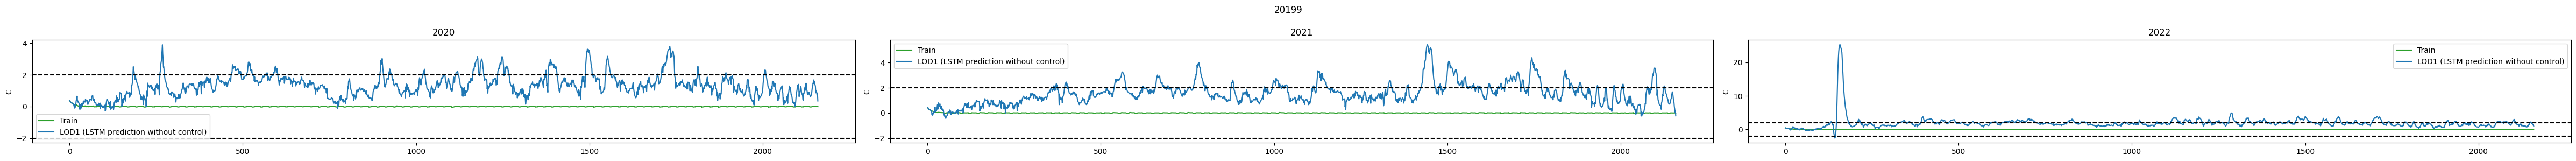

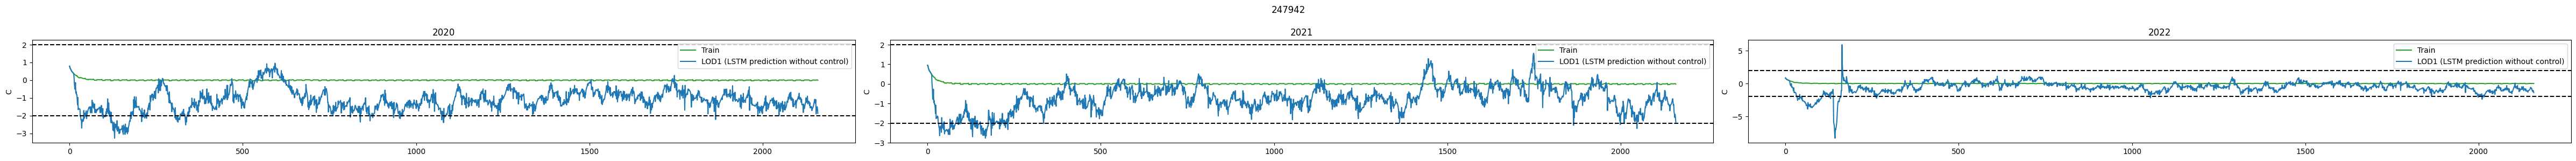

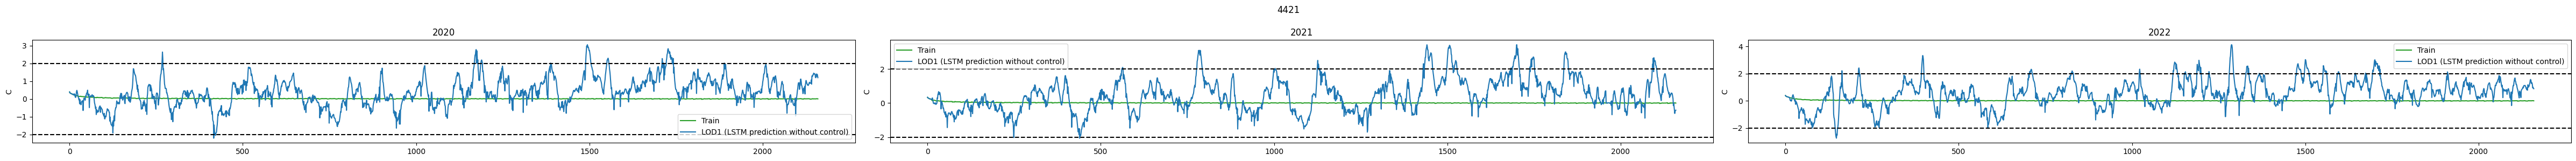

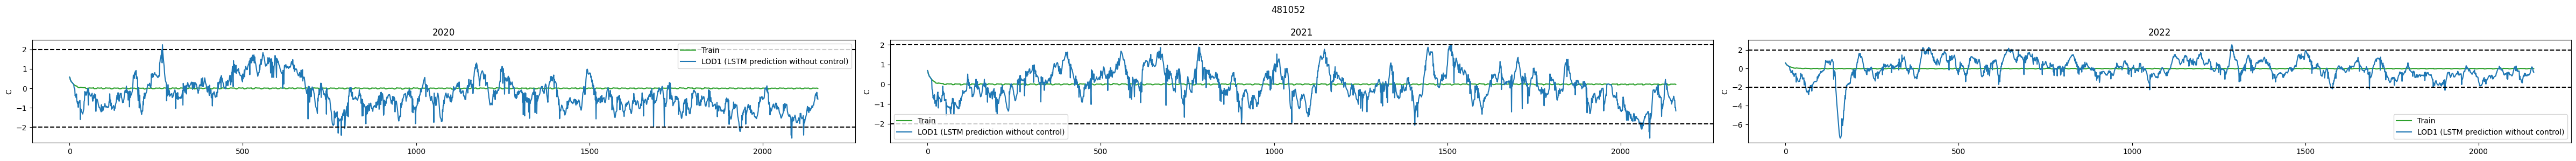

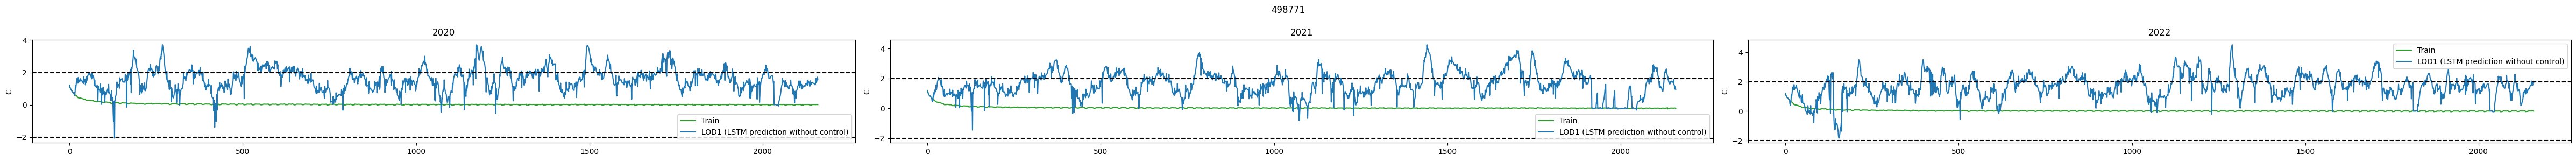

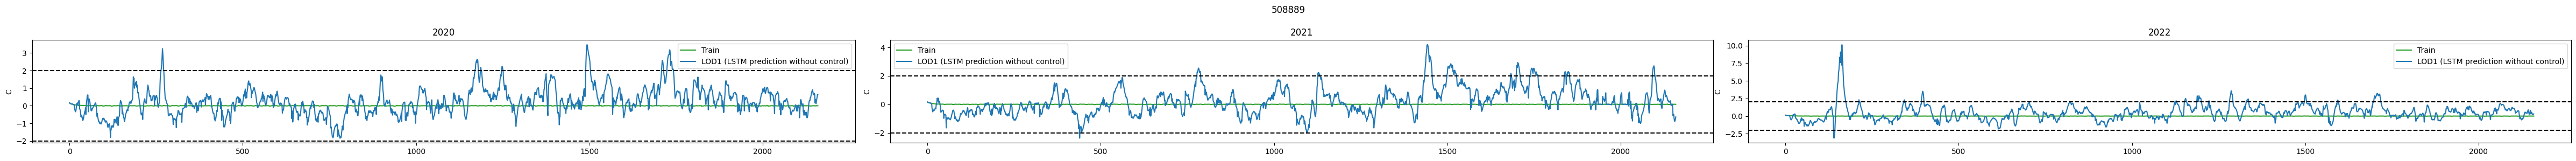

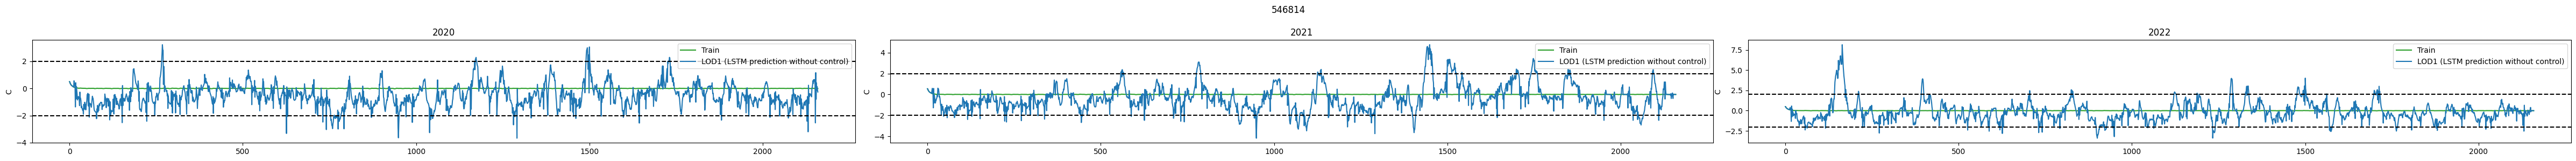

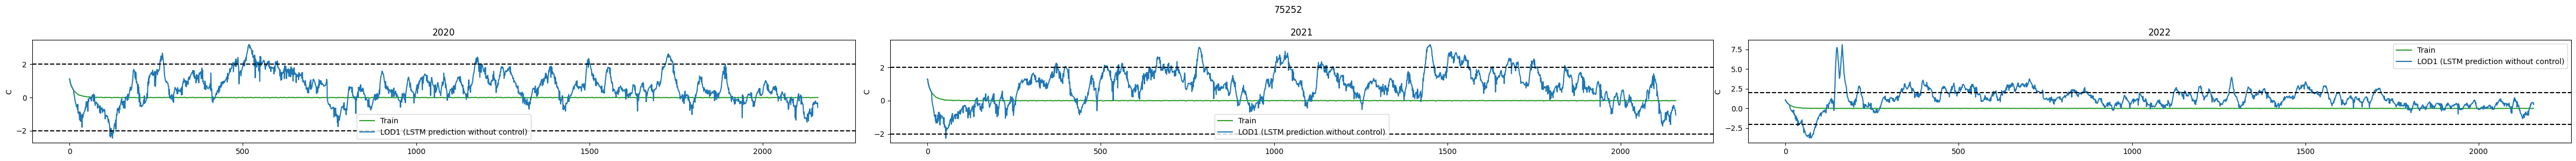

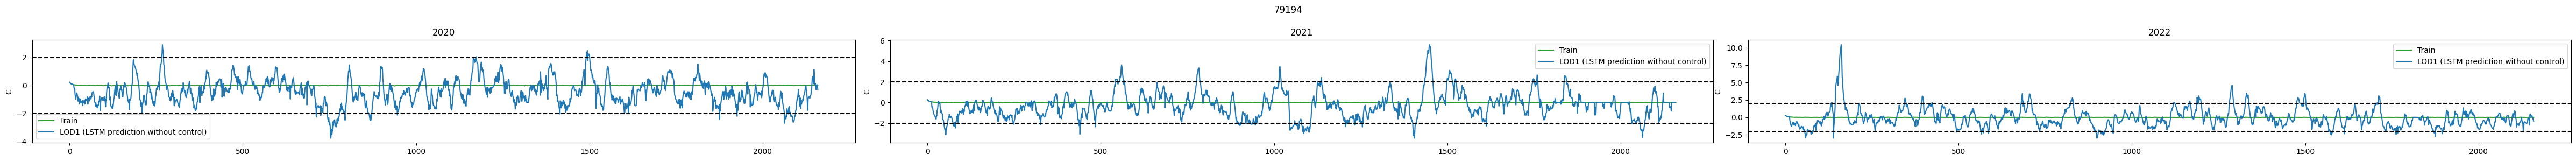

value                                          \
                           count      mean       std       min       25%   
bldg_name year reference                                                   
199613    2020 lod1_delta  994.0  2.440247  0.301598  2.000004  2.179664   
          2021 lod1_delta  868.0  2.343247  0.254286  2.000282  2.156596   
          2022 lod1_delta  873.0  2.313191  0.605203 -4.175182  2.111290   
20199     2020 lod1_delta  298.0  2.566863  0.442084  2.001211  2.204878   
          2021 lod1_delta  548.0  2.710606  0.696969  2.000694  2.172777   
          2022 lod1_delta  750.0  3.076366  3.065620 -2.636368  2.190049   
247942    2020 lod1_delta  131.0 -2.376734  0.320514 -3.267361 -2.657251   
          2021 lod1_delta  112.0 -2.240712  0.187357 -2.766254 -2.345246   
          2022 lod1_delta  103.0 -3.028353  1.697853 -8.326628 -3.369698   
4421      2020 lod1_delta   68.0  2.215516  0.977443 -2.211349  2.146966   
          2021 lod1_delta  144.0  2.536261  0.672744 -2.066456  2.226984   
          2022 lod1_delta  158.0  2.222644  1.149115 -2.743393  2.131032   
481052    2020 lod1_delta   12.0 -1.888705  1.312435 -2.566631 -2.411391   
          2021 lod1_delta   11.0 -1.850962  1.293281 -2.730675 -2.257871   
          2022 lod1_delta   83.0 -1.911221  3.194059 -7.478733 -3.928957   
498771    2020 lod1_delta  543.0  2.454758  0.456134 -2.063896  2.131450   
          2021 lod1_delta  702.0  2.533706  0.469450  2.001106  2.171365   
          2022 lod1_delta  743.0  2.497377  0.413847  2.000277  2.159273   
508889    2020 lod1_delta   61.0  2.564196  0.397993  2.036228  2.226000   
          2021 lod1_delta  124.0  2.492056  0.656234 -2.380270  2.204853   
          2022 lod1_delta  125.0  3.071436  2.060326 -3.133833  2.175261   
546814    2020 lod1_delta   89.0 -1.198509  2.146809 -3.670965 -2.429592   
          2021 lod1_delta  221.0  0.141146  2.711303 -4.182087 -2.489405   
          2022 lod1_delta  174.0  1.086109  3.020002 -3.393818 -2.189113   
75252     2020 lod1_delta  137.0  2.032716  1.163107 -2.442816  2.106775   
          2021 lod1_delta  283.0  2.396085  0.438858 -2.259611  2.127103   
          2022 lod1_delta  582.0  2.311314  1.728352 -3.784950  2.162083   
79194     2020 lod1_delta   92.0 -1.657501  1.861207 -3.769026 -2.608507   
          2021 lod1_delta  238.0 -0.078404  2.688450 -3.448717 -2.356770   
          2022 lod1_delta  196.0  1.545710  3.030832 -2.995375 -2.109500   

                                                          
                                50%       75%        max  
bldg_name year reference                                  
199613    2020 lod1_delta  2.393425  2.661045   3.395044  
          2021 lod1_delta  2.276532  2.509377   3.420702  
          2022 lod1_delta  2.271835  2.561226   3.624811  
20199     2020 lod1_delta  2.476102  2.791264   3.913527  
          2021 lod1_delta  2.545896  3.006251   5.422644  
          2022 lod1_delta  2.432088  2.905580  25.281910  
247942    2020 lod1_delta -2.280062 -2.095222  -2.003044  
          2021 lod1_delta -2.214044 -2.079741  -2.000797  
          2022 lod1_delta -2.752892 -2.306873   5.916988  
4421      2020 lod1_delta  2.296231  2.662347   3.053175  
          2021 lod1_delta  2.584924  2.877101   3.438599  
          2022 lod1_delta  2.336306  2.636207   4.131063  
481052    2020 lod1_delta -2.215157 -2.093207   2.246065  
          2021 lod1_delta -2.155474 -2.093501   2.005560  
          2022 lod1_delta -2.271145  2.041851   2.567278  
498771    2020 lod1_delta  2.333590  2.684230   3.716413  
          2021 lod1_delta  2.380535  2.780735   4.264441  
          2022 lod1_delta  2.392036  2.740974   4.530256  
508889    2020 lod1_delta  2.497820  2.868557   3.467115  
          2021 lod1_delta  2.379613  2.662549   4.194304  
          2022 lod1_delta  2.613371  3.125351  10.135092  
546814    2020 lod1_delta -2.136129 -2.010010   3.224497  
          2021 lod1_delta  2.028809  2.4173

In [4]:
settings = FileHandler.get_settings()
data = DataHandler.get_concat_data('lod_1', 'time_series')
data['year'] = data['id'].str.split('-', expand=True)[6].astype(int)
data_list = []

for bldg_name, bdata in data.groupby('bldg_name'):
    years = data['year'].unique()
    fig, ax = plt.subplots(1, len(years), figsize=(16*len(years), 3.0))

    for ax, (year, ydata) in zip(fig.axes, bdata.groupby('year')):
        ydata['train_delta'] = (ydata['indoor_dry_bulb_temperature_without_partial_load'] - ydata['indoor_dry_bulb_temperature_set_point_without_control']).tolist()
        ydata['lod1_delta'] = (ydata['indoor_dry_bulb_temperature'] - ydata['indoor_dry_bulb_temperature_set_point_without_control']).tolist()
        y1 = ydata['train_delta'].tolist()
        y2 = ydata['lod1_delta'].tolist()
        data_list.append(ydata)
        ax.plot(y1, color='tab:green', label='Train')
        ax.plot(y2, color='tab:blue', label='LOD1 (LSTM prediction without control)')
        ax.axhline(2.0, color='black', linestyle='--')
        ax.axhline(-2.0, color='black', linestyle='--')
        ax.set_ylabel('C')
        ax.set_title(f'{year}')
        ax.legend()
    
    fig.suptitle(bldg_name)
    plt.tight_layout()
    plt.show()

data = pd.concat(data_list, ignore_index=True)
data = data.melt(id_vars=['bldg_name', 'year'], value_vars=['train_delta', 'lod1_delta'], var_name='reference')
display(data[(data['value'].abs() > 2.0)].groupby(['bldg_name', 'year', 'reference'])[['value']].describe())

## LOD2 temperature and heating demand compared to LOD1

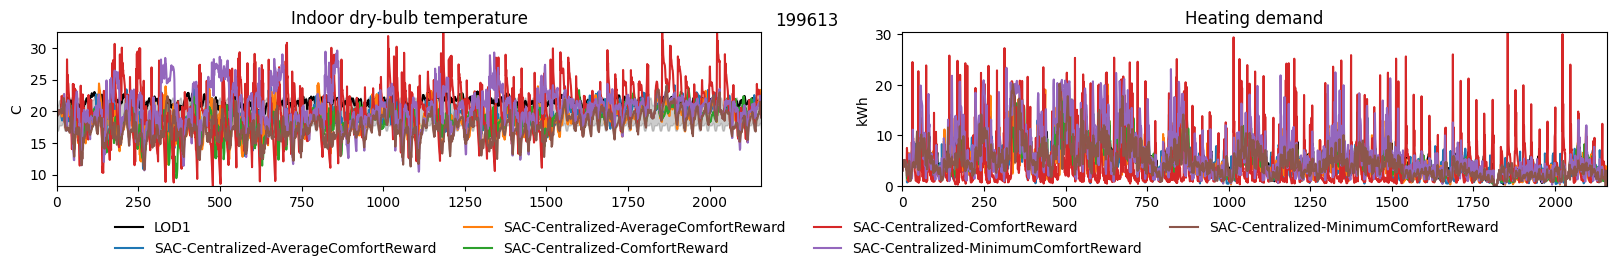

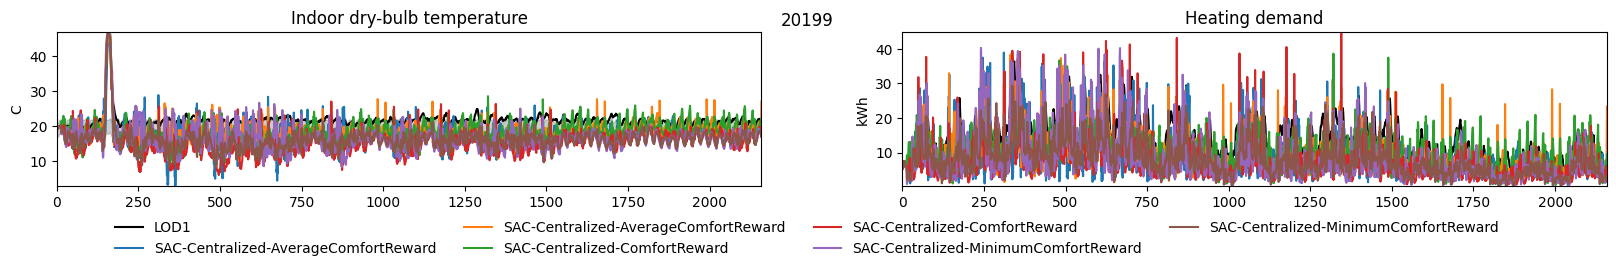

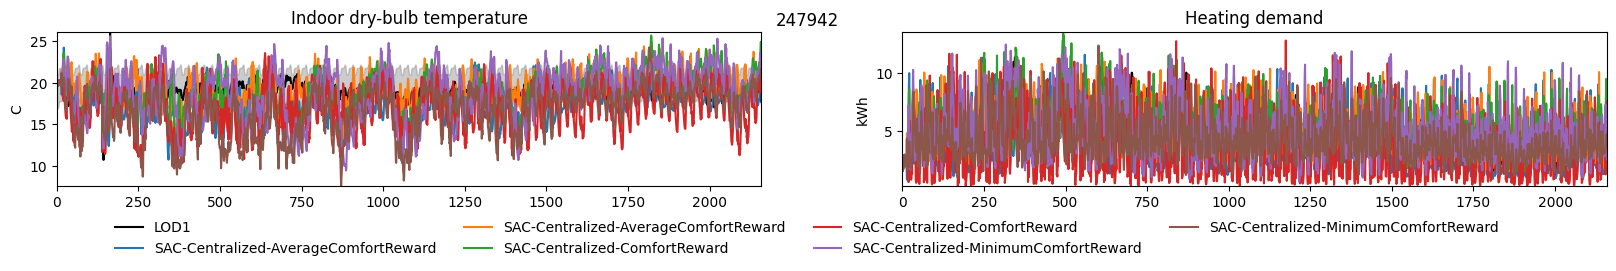

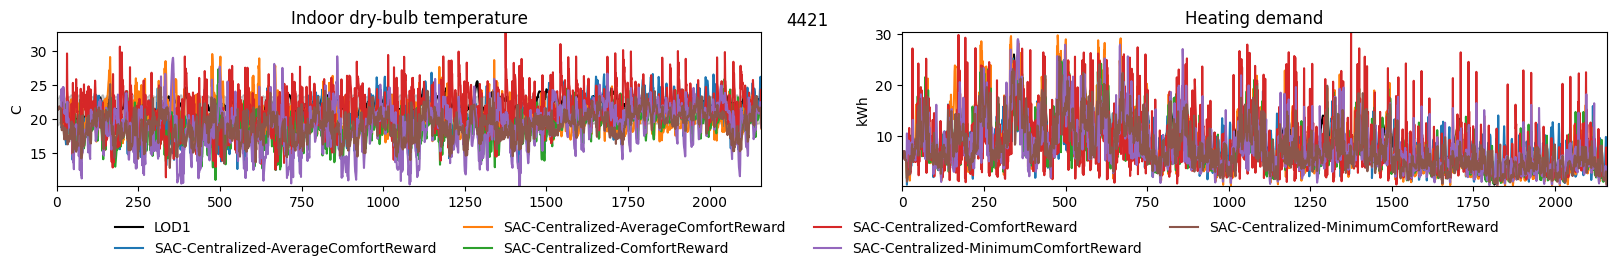

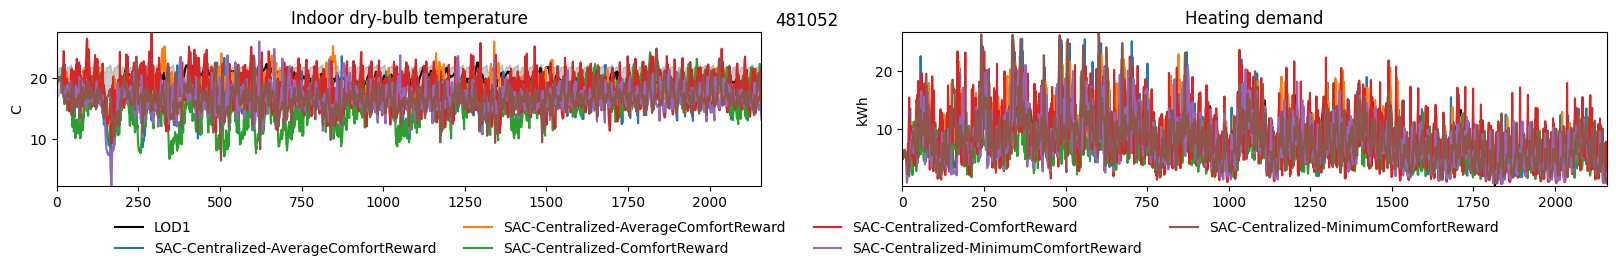

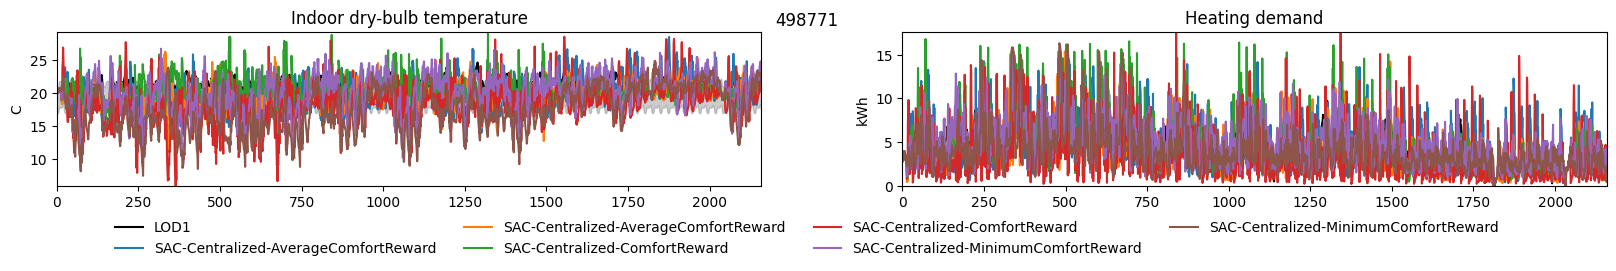

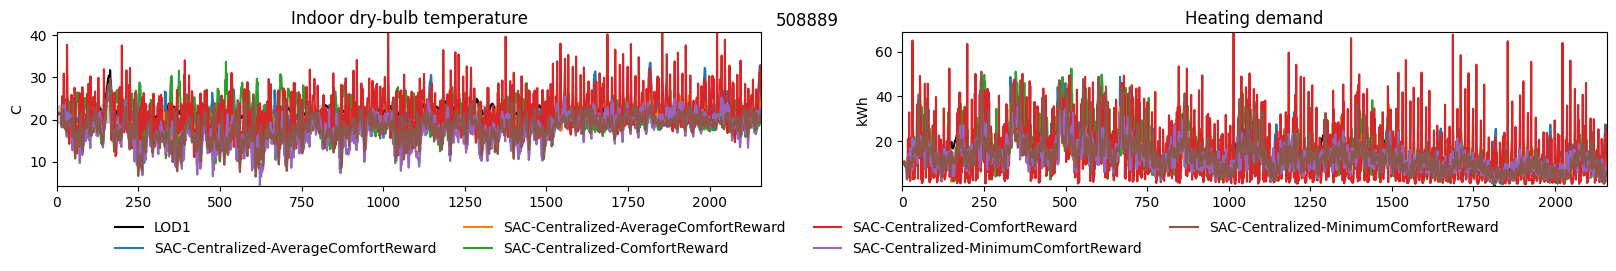

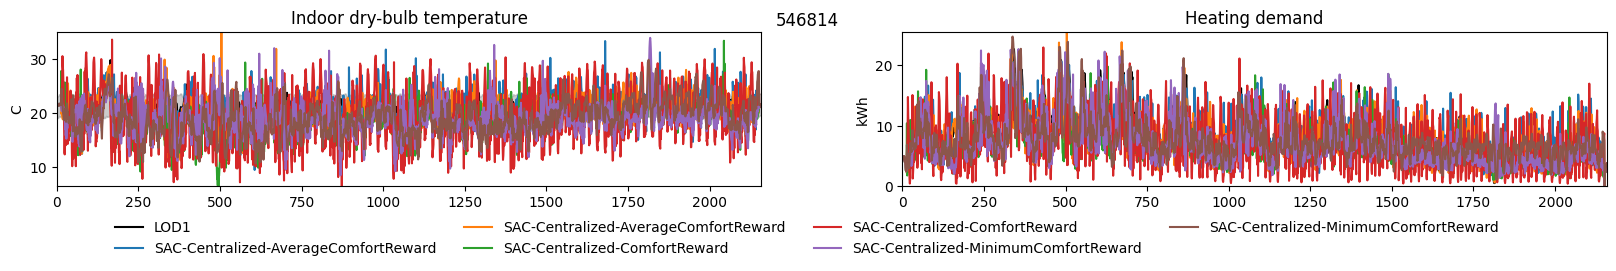

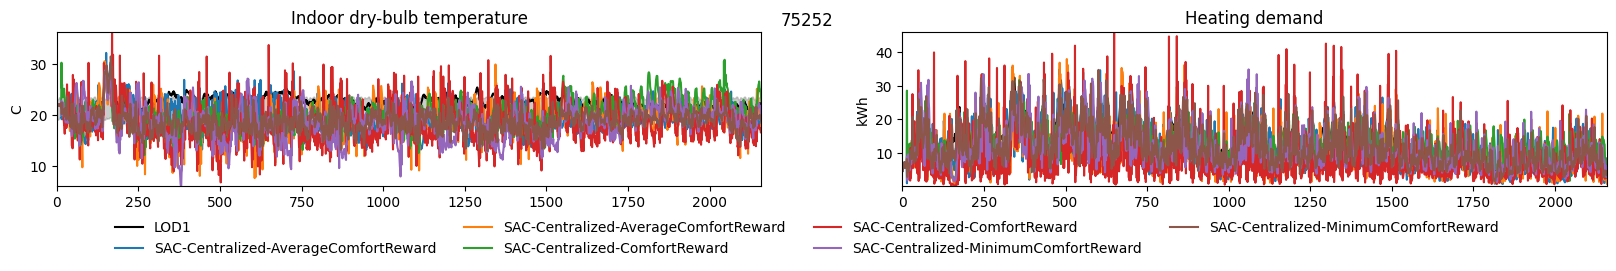

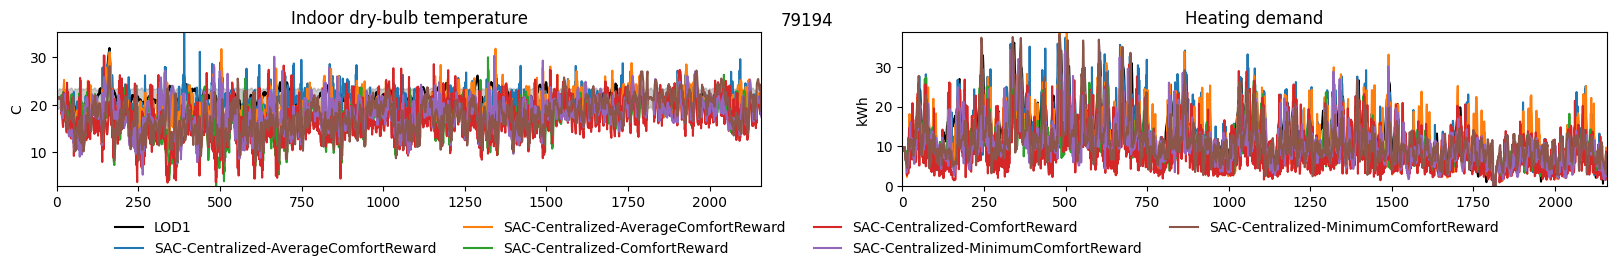

In [8]:
settings = FileHandler.get_settings()
lod1_data = DataHandler.get_concat_data('lod_1', 'time_series')
lod2_data = DataHandler.get_concat_data('building_all', 'time_series')
data = pd.concat([lod1_data, lod2_data], ignore_index=True)
# display_ids = [
#     'lod_1-citylearn-rbc-norbc-centralized-noreward-2022',
#     'lod_2-citylearn-sac-norbc-decentralized-comfortreward-2022',
#     # 'lod_2-citylearn-zeropowerheatpumprbc-norbc-centralized-noreward-2022',
#     # 'lod_2-citylearn-fullpowerheatpumprbc-norbc-centralized-noreward-2022',
#     # 'lod_2-stable_baselines3-sac-norbc-centralized-comfortreward-2022',
#     # 'lod_2-stable_baselines3-sac-norbc-centralized-minimumcomfortreward-2022',
#     'lod_2-stable_baselines3-sac-norbc-centralized-averagecomfortreward-2022',  
# ]
data['year'] = data['id'].map(lambda x: x.split('-')[-1]).astype(int)
data['level_of_detail'] = data['id'].str.split('-', expand=True)[0].str.split('_', expand=True)[1].astype(int)
data = data[
    (data['year']==2022) 
    # & (data['id'].isin(display_ids))
].copy()

for bldg_name, bdata in data.groupby('bldg_name'):
    fig, axs = plt.subplots(1, 2, figsize=(20, 2.0))

    # temperature
    y1 = bdata[bdata['level_of_detail']==1]['indoor_dry_bulb_temperature'].tolist()
    axs[0].plot(y1, color='black', label='LOD1')

    for (sid, agent, reward, central_agent), adata in bdata[bdata['level_of_detail']==2].groupby(['id', 'agent', 'reward_function_name', 'central_agent']):
        y = adata['indoor_dry_bulb_temperature'].tolist()
        axs[0].plot(y, label=f'{agent}-{central_agent}-{reward}')
    
    axs[0].set_title('Indoor dry-bulb temperature')
    axs[0].set_ylabel('C')
    y1 = adata['indoor_dry_bulb_temperature_set_point_without_control'] - 2.0
    y2 = adata['indoor_dry_bulb_temperature_set_point_without_control'] + 2.0
    axs[0].fill_between(range(len(y1)), y1, y2, color='grey', alpha=0.4)
    axs[0].margins(0)

    # demand
    y1 = bdata[bdata['level_of_detail']==1]['heating_demand_without_partial_load'].tolist()
    axs[1].plot(y1, color='black', label='LOD1')

    for (sid, agent, reward, central_agent), adata in bdata[bdata['level_of_detail']==2].groupby(['id', 'agent', 'reward_function_name', 'central_agent']):
        y = adata['heating_demand'].tolist()
        axs[1].plot(y, label=f'{agent}-{central_agent}-{reward}')
    
    axs[1].set_title('Heating demand')
    axs[1].set_ylabel('kWh')
    axs[1].margins(0)
    axs[1].legend(
        bbox_to_anchor=(0.5,0),
        loc='upper center', 
        bbox_transform=fig.transFigure,
        framealpha=0,
        ncol=4
    )

    fig.suptitle(bldg_name)
    plt.show()

- Taking the average comfort reward of all buildings in a centralized setting seems to perform better in terms of temperature delta than taking the minimum or sum. However, temperature still falls out of comfort band more often than not.
- Decentralized SAC does not make much difference compared to centralized SAC with average comfort reward.
- Will try increasing the exponents on the penalties to see how if affects performance.
- Maybe revisit the observations being used?

# KPIs
---

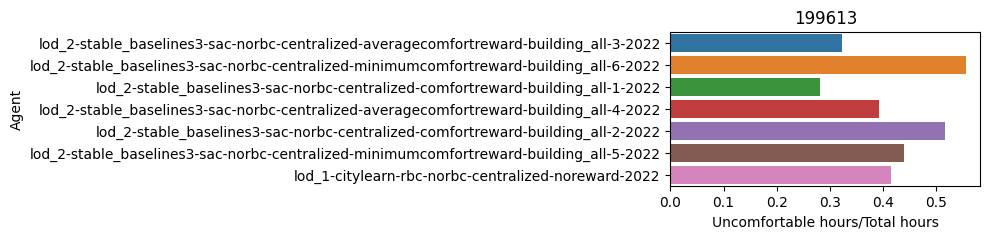

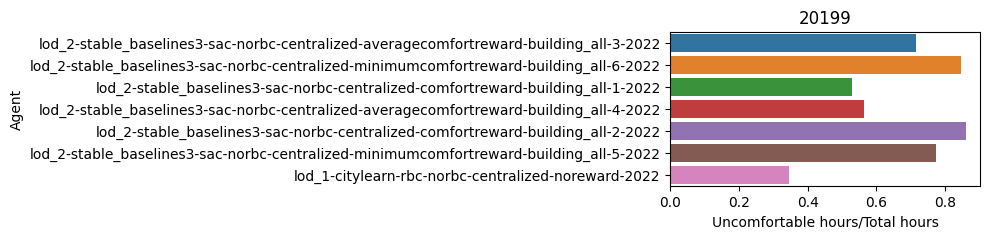

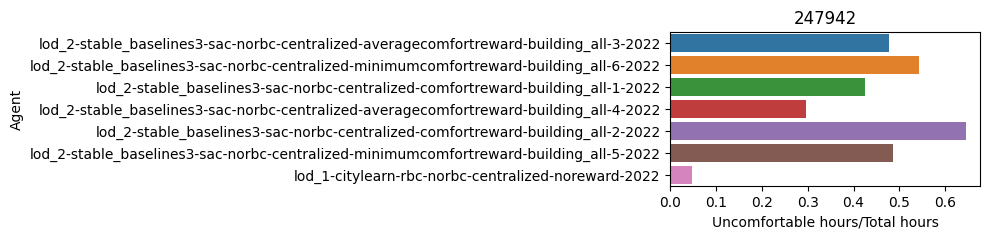

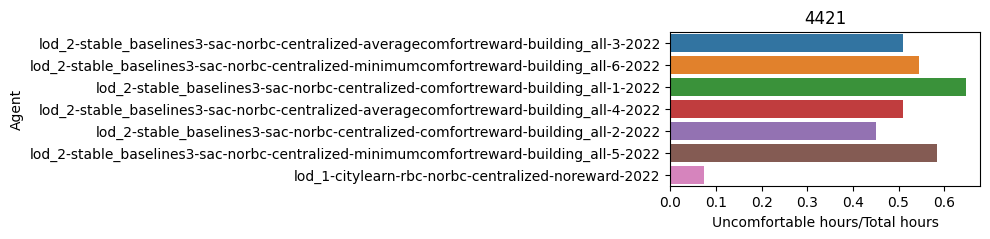

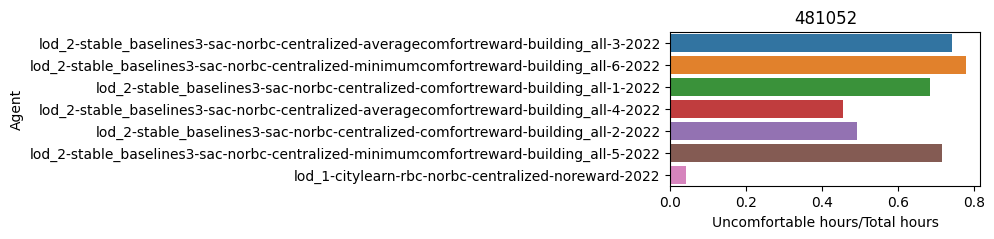

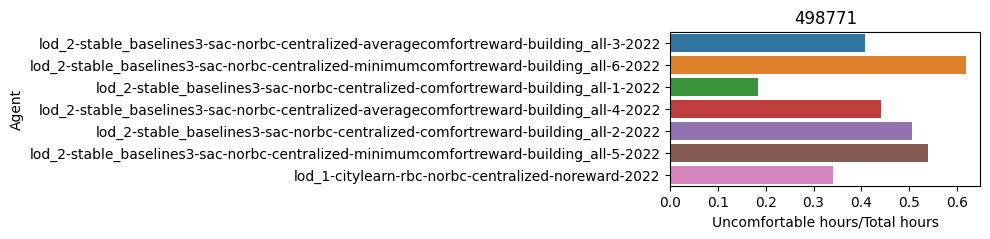

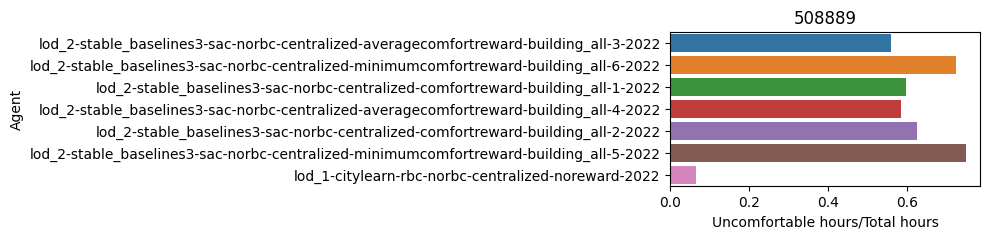

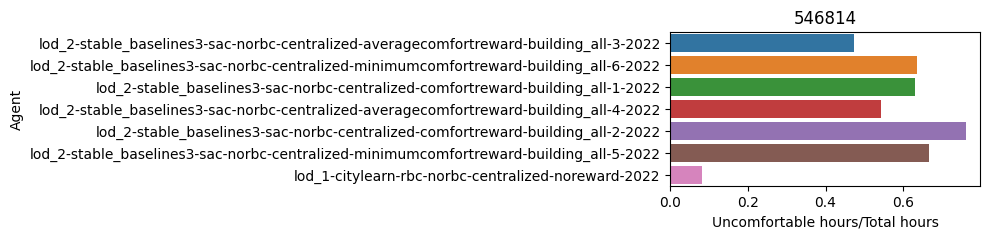

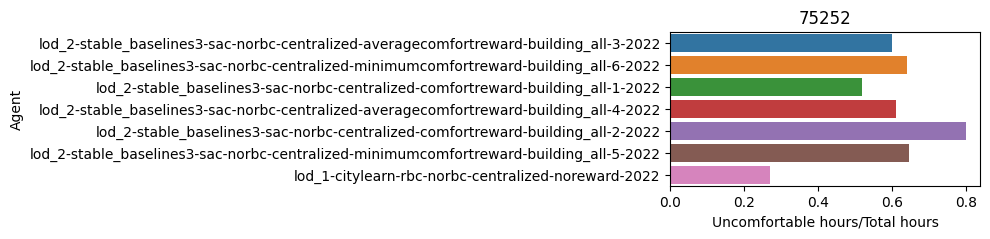

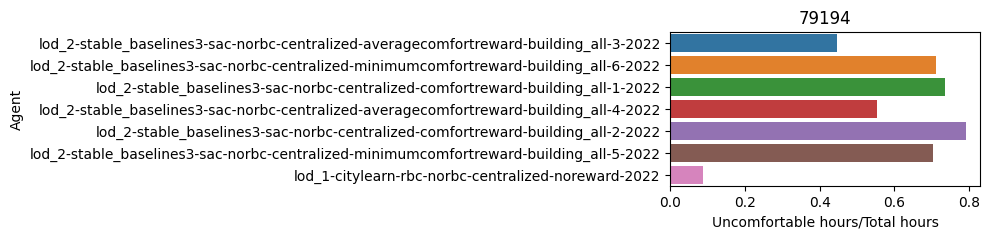

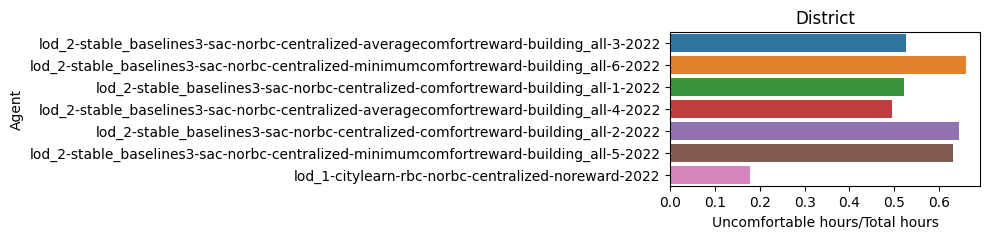

In [12]:
data = DataHandler.get_concat_data('lod', 'evaluation')
data['year'] = data['id'].map(lambda x: x.split('-')[-1]).astype(int)
data['level_of_detail'] = data['id'].str.split('-', expand=True)[0].str.split('_', expand=True)[1].astype(int)
data = data[
    ((data['year']==2022) & (data['level_of_detail']==1))
    | ((data['id'].str.split('-', expand=True)[6]=='building_all') & (data['level_of_detail']==2))
].copy()

data['agent_label'] = data['agent'] + '-' + data['central_agent'] + '-' + data['reward_function_name']
data.loc[data['level_of_detail']==1, 'agent_label'] = 'LOD1'
# value_vars = [c for c in data.columns if c in DataHandler.KPI_LABELS.keys()]
data = data.melt(id_vars=['agent_label', 'id', 'environment'], value_vars=['discomfort_proportion'])
data['value'] = pd.to_numeric(data['value'])

for e, edata in data.groupby('environment'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    sns.barplot(
        x='value',
        y='id',
        data=edata,
        ax=ax,
    )
    ax.set_title(e)
    ax.set_xlabel('Uncomfortable hours/Total hours')
    ax.set_ylabel('Agent')
    plt.show()

# Reward Convergence
---

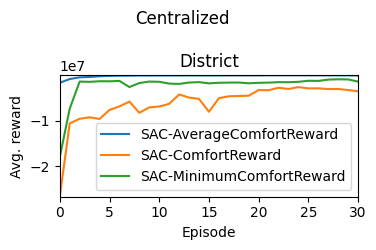

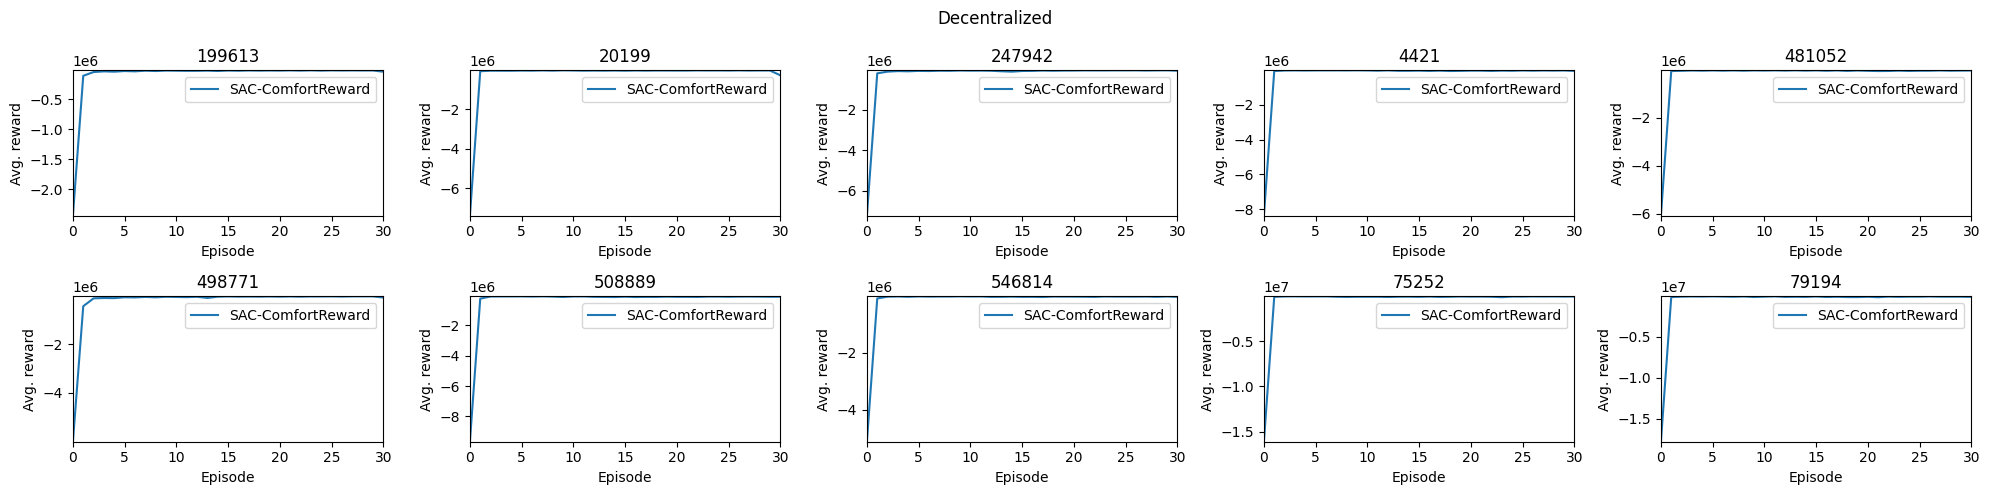

In [ ]:
data = DataHandler.get_concat_data('lod_2', 'rewards')
data = data[data['reward_function_name']!='NoReward'].copy()
column_count_limit = 5

for central_agent, cdata in data.groupby('central_agent'):
    environment_count = len(cdata['environment'].unique())
    row_count = math.ceil(environment_count/column_count_limit)
    column_count = min(environment_count, column_count_limit)
    fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count, 2.5*row_count))

    for ax, (environment, edata) in zip(fig.axes, cdata.groupby('environment')):
        ax.set_title(environment)
        ax.set_xlabel('Episode')
        ax.set_ylabel('Avg. reward')
        ax.margins(0)

        for (agent, reward), adata in edata.groupby(['agent', 'reward_function_name']):
            x = adata['episode'].tolist()
            y = adata['sum'].tolist()
            ax.plot(x, y, label=f'{agent}-{reward}')
        
        # ax.axis('off')
        ax.legend()
        
    fig.suptitle(f'{central_agent}')
    plt.tight_layout()
    plt.show()